<a href="https://colab.research.google.com/github/cristinakuo/thesis-pre-research/blob/master/CTC_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!git clone --recursive https://github.com/parlance/ctcdecode.git
!cd ctcdecode && pip install .

Cloning into 'ctcdecode'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 1059 (delta 5), reused 7 (delta 2), pack-reused 1047
Receiving objects: 100% (1059/1059), 759.79 KiB | 13.57 MiB/s, done.
Resolving deltas: 100% (508/508), done.
Submodule 'third_party/ThreadPool' (https://github.com/progschj/ThreadPool.git) registered for path 'third_party/ThreadPool'
Submodule 'third_party/kenlm' (https://github.com/kpu/kenlm.git) registered for path 'third_party/kenlm'
Cloning into '/content/ctcdecode/third_party/ThreadPool'...
remote: Enumerating objects: 82, done.        
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82        
Cloning into '/content/ctcdecode/third_party/kenlm'...
remote: Enumerating objects: 86, done.        
remote: Counting objects: 100% (86/86), done.        
remote: Compressing objects: 100% (60/60), done.        
remote: Total 13668 (delta 39), reused 53

In [4]:
import torch
import torch.nn as nn
import tqdm

print("CUDA available: ", torch.cuda.is_available())
dev = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)  

# ------------------------------ Loading of raw data ------------------------------

# Load files: out_lab_fea_xx.pkl
# Saves the dictionary total_set in 3 files 
# that should contain train, dev and test data (in any order)

import pickle
import numpy as np

out_folder = '/content/gdrive/My Drive/Tesis/data/'
xi = 3 # Name of the 3 files (train, dev y test) 
xf = 6

total_set = dict()
for i in range(xi,xf):
    idf = str(i)
    out_file = 'out_lab_fea_' + idf + '.pkl'

    with open(out_folder+out_file,'rb') as f:
        total = pickle.load(f)
    total_set[total[5]] = total
    
data_name_train = total_set['train'][0]
data_end_index_train = total_set['train'][1]
fea_dict_train = total_set['train'][2]
lab_dict_train = total_set['train'][3]
data_set_train = total_set['train'][4]
todo_train = total_set['train'][5]

data_name_dev = total_set['dev'][0]
data_end_index_dev = total_set['dev'][1]
fea_dict_dev = total_set['dev'][2]
lab_dict_dev = total_set['dev'][3]
data_set_dev = total_set['dev'][4]
todo_dev = total_set['dev'][5]

data_name_test = total_set['test'][0]
data_end_index_test = total_set['test'][1]
fea_dict_test = total_set['test'][2]
lab_dict_test = total_set['test'][3]
data_set_test = total_set['test'][4]
todo_test = total_set['test'][5]

# Check number of phrases in transcripts
nr_phrases_train = len(data_name_train)
nr_phrases_test = len(data_name_test)

print('Nr of phrases (train): ', nr_phrases_train)
print('Nr of phrases (test): ', nr_phrases_test)

# Split into sequences according to end indices
train_sequences = np.split(data_set_train, data_end_index_train)[:-1] # Last item is empty
test_sequences = np.split(data_set_test, data_end_index_test)[:-1]

# Conver to tensor
train_sequences = [torch.from_numpy(seq) for seq in train_sequences]
test_sequences = [torch.from_numpy(seq) for seq in test_sequences]
print('Train: split data into {} phrases.'.format(len(train_sequences)))
print('Test: split data into {} phrases.'.format(len(test_sequences)))

vocab_list = ['aa','ae','ah','ao','aw','ax','ax-h','axr','ay','b','bcl','ch',
              'd','dcl','dh','dx','eh','el','em','en','eng','epi','er','ey',
              'f','g','gcl','h#','hh','hv','ih','ix','iy','jh','k','kcl','l',
              'm','n','ng','nx','ow','oy','p','pau','pcl','q','r','s','sh',
              't','tcl','th','uh','uw','ux','v','w','y','z','zh', '_']


CUDA available:  True
Nr of phrases (train):  3696
Nr of phrases (test):  192
Train: split data into 3696 phrases.
Test: split data into 192 phrases.


In [5]:
# Utils

def collapse_repeated(sequence):
  """
  Receives list of labels and remove the ones that are repeated consecutively
  
  E.g. [27 27 28 28 28] -> [27, 28]

  """

  if len(sequence) == 0:
    return sequence
  
  diff = np.diff(sequence).astype(np.bool)
  idx = np.insert(diff, 0, True)
  sequence_reduced = sequence[idx]

  return sequence_reduced

def print_distances(distances, token1Length, token2Length):
  for t1 in range(token1Length + 1):
      for t2 in range(token2Length + 1):
          print(int(distances[t1][t2]), end=" ")
      print()

def levenshtein_distance(token1, token2, debug=False):
  """
  Computes the Edit Distance between two sequences.
  """
  distances = numpy.zeros((len(token1) + 1, len(token2) + 1))

  for t1 in range(len(token1) + 1):
    distances[t1][0] = t1

  for t2 in range(len(token2) + 1):
    distances[0][t2] = t2
        
  a = 0
  b = 0
  c = 0
  
  for t1 in range(1, len(token1) + 1):
    for t2 in range(1, len(token2) + 1):
      if (token1[t1-1] == token2[t2-1]):
          distances[t1][t2] = distances[t1 - 1][t2 - 1]
      else:
          a = distances[t1][t2 - 1]
          b = distances[t1 - 1][t2]
          c = distances[t1 - 1][t2 - 1]             
          min_dist = min((a,b,c))

          distances[t1][t2] = min_dist + 1

  if debug:
    print_distances(distances, len(token1), len(token2))
    
  return distances[len(token1)][len(token2)]


In [7]:
# Decoding
from dataclasses import dataclass
from typing import List
from ctcdecode import CTCBeamDecoder

# *********************************************************************** #
#                           Decoding
# *********************************************************************** #
@dataclass 
class Decoder():
  blank_label: int
  remove_blanks: bool = True
  collapse_repeated: bool = True

  def decode(self, sequences, sequence_lens=None, *args, **kwargs):
    pass

  def _post_process(self, decoded_seq):
    if self.collapse_repeated:
      decoded_seq = collapse_repeated(decoded_seq.cpu())
      decoded_seq = decoded_seq.to(dev)
      
    if self.remove_blanks:
      decoded_seq = decoded_seq[decoded_seq != self.blank_label]

    return decoded_seq

@dataclass
class GreedyDecoder(Decoder):

  def decode(self, sequences, sequence_lens=None, *args, **kwargs):
    """
    For each timestemp, takes the label with maximum probability.
    Optionally removes consecutively repeated labels and blank labels.
  
    :param sequences: torch tensor [batch, sequence len, number of classes]
    :param sequence_lens: list of sequence lengths for each sequence in batch
    :return: list of decoded sequences (different lengths).
    """

    decoded_sequences = []
    for sequence, seq_len in zip(sequences, sequence_lens):
      seq = sequence[:seq_len]  # Remove pads
      decoded_seq = torch.argmax(seq, dim=1)
    
      decoded_seq = self._post_process(decoded_seq)

      decoded_sequences.append(decoded_seq)

    return decoded_sequences

@dataclass
class BeamSearchDecoder(Decoder):
  labels: List = None
  model_path: str = None
  alpha: float = 0.0
  beta: float = 0.0 
  cutoff_top_n: int = 40
  cutoff_prob: float = 1.0
  beam_width: int = 3
  num_processes: int = 4
  blank_id: int = 0
  log_probs_input: bool = True

  def __post_init__(self):
    self._decoder = CTCBeamDecoder(labels=self.labels,
                                   model_path=self.model_path,
                                   alpha=self.alpha,
                                   beta=self.beta,
                                   cutoff_top_n=self.cutoff_top_n,
                                   cutoff_prob=self.cutoff_prob,
                                   beam_width=self.beam_width,
                                   num_processes=self.num_processes,
                                   blank_id=self.blank_id, # This should be the index of the CTC blank token # Maybe it should be blank_label - 1?
                                   log_probs_input=self.log_probs_input)
    
  def decode(self, sequences, sequence_lens=None, *args, **kwargs):
    """
    :param sequences: [batch, number of timesteps, number of classes]
    """
    beam_result, beam_scores, timesteps, out_seq_len = self._decoder.decode(sequences, )
    # beam_result [batchsize, n_beams, n_timesteps]
    # TODO: convert to decoded output and return
    decoded_sequences = []

    for sequence,out_len in zip(beam_result, out_seq_len):
      beam_number = 0
      decoded_sequence = sequence[beam_number][:out_len[beam_number]]
      decoded_sequence = decoded_sequence.to(device)
      
      decoded_sequence = self._post_process(decoded_sequence)

      decoded_sequences.append(decoded_sequence)

    return decoded_sequences


def label_error_rate(predicted_sequences, target_sequences, predicted_lens, target_lens, debug=False):
  total_distance = 0
  
  nr_batches = len(predicted_sequences)

  for i in range(nr_batches):
    pred_seq = predicted_sequences[i]
    target_seq = target_sequences[i]
    predicted_len = predicted_lens[i]
    target_len = target_lens[i]

    pred_seq = pred_seq[:predicted_len]
    target_seq = target_seq[:target_len]

    dist = levenshtein_distance(pred_seq, target_seq)
    total_distance += dist

  target_total_len = sum(target_lens)
  label_err_rate = float(total_distance)/float(target_total_len)*100  # Although LER it's not a real percentage, as it could be > %100
  
  if debug:
    print("Total distance ", total_distance)
    print("Target total len ", target_total_len)

  return label_err_rate

In [10]:
import numpy
import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import torch.optim as optim
from torch.nn import CTCLoss, LogSoftmax
from torch.nn.functional import log_softmax

FEATURE_DIM = 13 
NR_PHONEMES = 61
BLANK_LABEL = 61  # 0 to 60 are used
PADDING_VALUE = -1 


# *********************************************************************** #
#                           Hyper parameters
# *********************************************************************** #

BATCH_SIZE = 3
NUM_EPOCHS = 20
learning_rate = 0.01
momentum = 0.9
hidden_size = 100
layer_size = 2 # Number of layers

BEAM_WIDTH = 3 # Only used if decoding with Beam search

decoder = GreedyDecoder(blank_label=BLANK_LABEL)
decoder = BeamSearchDecoder(labels=vocab_list, blank_label=BLANK_LABEL, 
                            beam_width=BEAM_WIDTH, log_probs_input=True,
                            blank_id=BLANK_LABEL)

# *********************************************************************** #
#                             Dataset
# *********************************************************************** #

class SpeechDataset(Dataset):
  def __init__(self, list_of_sequences):
    self.data = list_of_sequences
    self.n_samples = len(list_of_sequences)
    self.seq_lens = [len(seq) for seq in list_of_sequences]
    self.n_frames = sum(self.seq_lens)

  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return self.n_samples


train_dataset = SpeechDataset(train_sequences)
test_dataset = SpeechDataset(test_sequences)

print("Train Samples: {}".format(len(train_dataset)))
print("Train frames: ", train_dataset.n_frames)
print("Test Samples: {}".format(len(test_dataset)))
print("Test frames: ", test_dataset.n_frames)
print()


def collate_timit(batch):
    """
    batch: list of numpy arrays of different lengths
    """
    # Get length for each sequence
    input_lens = [sequence.shape[0] for sequence in batch]
    
    # Pad sequences to max length in batch
    batch_padded = pad_sequence(batch, batch_first=True, padding_value=PADDING_VALUE)
    batch_padded = torch.as_tensor(batch_padded)
    
    # Get batched input
    x_batch = batch_padded[:,:,:-1]
    
    # Obtain targets
    y_batch = [seq[:,-1] for seq in batch]

    # Remove repeated consecutive labels in target sequences: (E.g. [27 27 28 28 28 61] -> [27 28 61])
    # NOTE: This is done to make targets shorter than input, so that nn.CTCLoss doesn't yield infinite values
    y_batch_reduced = []
    target_lens = []
    for y_seq in y_batch: # Loop over each sequence
      y_seq_reduced = collapse_repeated(y_seq)
      y_batch_reduced.append(y_seq_reduced)
      target_lens.append(len(y_seq_reduced))

    # Pad target sequences
    y_batch_padded = pad_sequence(y_batch_reduced, batch_first=True, padding_value=PADDING_VALUE)
    
    y_batch = torch.as_tensor(y_batch_padded)
    
    return x_batch, y_batch, input_lens, target_lens


# *********************************************************************** #
#                           Model
# *********************************************************************** #

class BLSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, nr_layers, output_size):
    super(BLSTMModel, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.nr_layers = nr_layers

    # Hidden layer
    # batch_first=True means input/output tensors to be of shape
    # (batch_dim, seq_dim, feature_dim)
    self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.nr_layers, 
                        batch_first=True, bidirectional=True, bias=True)
    
    # Output Layer
    # Input is hidden_size*2 because it has a bidirectional LSTM as previous layer
    self.fc = torch.nn.Linear(self.hidden_size*2, self.output_size, bias=True)

    self.log_softmax = LogSoftmax(dim=2)

  def forward(self, x, seq_lens): # x has shape [batch_size, max_seq_len, nr_coef]

    x_packed = pack_padded_sequence(x, lengths=seq_lens, batch_first=True, enforce_sorted=False) # x_packed.data has shape [nr_batch_frames, nr_coefs]
    out_lstm, _ = self.lstm(x_packed) # out_lstm.data has shape [nr_batch_frames, nr_coefs]

    out_lstm_padded, out_lens = pad_packed_sequence(out_lstm, batch_first=True, padding_value=PADDING_VALUE) # [batch_size, sequences_max_len, nr_coefs]

    out = self.fc(out_lstm_padded) # [batch_size, sequences_max_len, nr_classes] 
    # CTCLoss will ignore the padding values as sequences lengths from input and target are passed to it

    
    return out, out_lens


# *********************************************************************** #
#                        Train & Test functions
# *********************************************************************** #

def train_model(model, data_loader):

  model.train()
  
  epoch_loss = 0

  for batch_idx, (input_data, target_data, seq_lens, target_lens) in enumerate(tqdm.notebook.tqdm((data_loader))): 
    # Save to device
    input_data = input_data.to(torch.float)
    target_data = target_data.to(torch.long)
    input_data, target_data = input_data.to(device), target_data.to(device)
    
    optimizer.zero_grad() # Clear grads before doing backward
    
    # Forward pass
    model_out, out_lens = model(input_data, seq_lens) # [batch_size, seq_len, classes]

    # Prepare CTC inputs
    model_out = log_softmax(model_out, dim=2) # [batch_size, sequences_max_len, nr_classes]
    model_out_permuted = model_out.permute(1,0,2) # [seq_len, batch_size, classes] 
    input_lens = out_lens.to(torch.long)
    target_lens = torch.tensor(target_lens, dtype=torch.long)

    batch_loss = cost_function(model_out_permuted.cpu(), target_data.cpu(), input_lens.cpu(), target_lens.cpu())
    epoch_loss += batch_loss.item()
    
    # Backward pass
    batch_loss.backward()
    optimizer.step()

  epoch_loss = epoch_loss/len(data_loader.dataset) # Divide by number of sequences

  return epoch_loss

def test_model(model, data_loader):

  # This will notify all the layers that it's eval mode, that way, 
  # batchnorm or dropout layers will work in eval mode instead of training mode.
  model.eval()

  total_loss = 0
  nr_correct_frames = 0
  total_frames = 0
  label_err_rates = []
  
  # no_grad impacts the autograd engine and deactivate it. 
  # It will reduce memory usage and speed up computations 
  # and it won’t be able to backprop (which is not desired 
  # in an eval script).
  with torch.no_grad(): 
    for batch_idx, (input_data, target_data, seq_lens, target_lens) in enumerate(tqdm.notebook.tqdm((data_loader))):
      input_data = input_data.to(torch.float)
      target_data = target_data.to(torch.long)
      input_data, target_data = input_data.to(device), target_data.to(device)  
      
      model_out, out_lens = model(input_data, seq_lens)

      # Prepare CTC inputs
      model_out = log_softmax(model_out, dim=2) # [batch_size, sequences_max_len, nr_classes]
      model_out_permuted = model_out.permute(1,0,2) # [seq_len, batch_size, classes] 
      input_lens = out_lens.to(torch.long)
      target_lens = torch.tensor(target_lens, dtype=torch.long) 

      # Compute loss
      batch_loss = cost_function(model_out_permuted.cpu(), target_data.cpu(), input_lens.cpu(), target_lens.cpu())
      total_loss += batch_loss.item()

      # Predict
      #predictions = greedy_decoding(model_out, input_lens, blank_label=BLANK_LABEL, 
      #                              remove_blanks=True, collapse_repeated=True)
      
      predictions = decoder.decode(model_out, input_lens)
      
      # Get error
      label_err_rate = label_error_rate(predictions, target_data, input_lens, target_lens)
      label_err_rates.append(label_err_rate)

  average_loss = total_loss/len(data_loader.dataset) # Divide by number sequences
  avg_label_err_rate = sum(label_err_rates)/len(label_err_rates)

  print(label_err_rates)
  print(avg_label_err_rate)

  return average_loss, avg_label_err_rate


# **************************** Instantiate model & train ******************************** #

input_size = FEATURE_DIM
output_size = NR_PHONEMES + 1  # Number of phonemes + 1 for blank label

model = BLSTMModel(input_size, hidden_size, layer_size, output_size)
model = model.to(device)

cost_function = nn.CTCLoss(blank=BLANK_LABEL, zero_infinity=False)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

print("Created BLSTM model with parameters:")
print("Input size: ", input_size)
print("Hidden size: ", hidden_size)
print("Layer size: ", layer_size)
print("Output size: ", output_size)
print("Batch size: ", BATCH_SIZE)

losses = []
label_error_rates = []

for epoch in range(NUM_EPOCHS):
  print("Epoch nr: ", epoch + 1)

  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_timit)
  train_loss = train_model(model, train_loader)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_timit)
  test_loss, test_label_error_rate = test_model(model, test_loader)
  losses.append(test_loss)
  label_error_rates.append(test_label_error_rate)
  print("---- Training results ----")
  print("Loss:", train_loss)
  print("---- Test results ----")
  print("Loss:", test_loss)
  print("Label error rate:", test_label_error_rate)
  print()

Train Samples: 3696
Train frames:  1124823
Test Samples: 192
Test frames:  57919

Created BLSTM model with parameters:
Input size:  13
Hidden size:  100
Layer size:  2
Output size:  62
Batch size:  3
Epoch nr:  1



[96.49122807017544, 98.0392156862745, 97.43589743589743, 96.875, 100.0, 98.52941176470588, 98.79518072289156, 96.73913043478261, 97.05882352941177, 96.5909090909091, 98.98989898989899, 99.01960784313727, 98.91304347826086, 98.73417721518987, 98.9010989010989, 97.77777777777777, 98.09523809523809, 98.18181818181819, 96.29629629629629, 97.5, 97.72727272727273, 98.21428571428571, 100.0, 97.19626168224299, 97.2972972972973, 96.96969696969697, 98.9795918367347, 96.62921348314607, 98.18181818181819, 97.5, 96.96969696969697, 97.36842105263158, 98.29059829059828, 97.27272727272728, 96.93877551020408, 97.87234042553192, 98.26086956521739, 98.31932773109243, 98.27586206896551, 99.04761904761905, 100.0, 97.77777777777777, 99.21875, 99.09909909909909, 97.61904761904762, 97.79411764705883, 98.07692307692307, 97.65625, 98.4251968503937, 97.85714285714285, 98.11320754716981, 98.31932773109243, 98.15950920245399, 98.125, 98.75776397515527, 98.64864864864865, 98.02631578947368, 98.0, 98.125, 98.255813


[92.98245614035088, 96.07843137254902, 88.46153846153845, 93.75, 93.33333333333333, 94.11764705882352, 95.18072289156626, 94.56521739130434, 92.64705882352942, 95.45454545454545, 94.94949494949495, 94.11764705882352, 94.56521739130434, 89.87341772151899, 92.3076923076923, 88.88888888888889, 95.23809523809523, 91.81818181818183, 96.29629629629629, 96.25, 96.5909090909091, 91.96428571428571, 91.2621359223301, 95.32710280373831, 95.4954954954955, 91.91919191919192, 91.83673469387756, 94.3820224719101, 95.45454545454545, 96.66666666666667, 91.91919191919192, 93.85964912280701, 97.43589743589743, 96.36363636363636, 94.89795918367348, 92.90780141843972, 89.56521739130436, 93.27731092436974, 89.65517241379311, 96.19047619047619, 88.33333333333333, 94.07407407407408, 97.65625, 93.69369369369369, 94.44444444444444, 93.38235294117648, 96.15384615384616, 92.96875, 95.2755905511811, 92.14285714285714, 92.45283018867924, 96.63865546218487, 88.95705521472392, 95.625, 95.03105590062113, 93.918918918


[75.43859649122807, 80.3921568627451, 64.1025641025641, 68.75, 68.0, 61.76470588235294, 69.87951807228916, 73.91304347826086, 67.64705882352942, 67.04545454545455, 70.70707070707071, 67.64705882352942, 65.21739130434783, 75.9493670886076, 59.34065934065934, 70.0, 67.61904761904762, 73.63636363636363, 67.90123456790124, 75.0, 78.4090909090909, 62.5, 62.13592233009708, 67.28971962616822, 76.57657657657657, 67.67676767676768, 69.38775510204081, 67.41573033707866, 73.63636363636363, 71.66666666666667, 75.75757575757575, 59.64912280701754, 69.23076923076923, 71.81818181818181, 65.3061224489796, 68.08510638297872, 68.69565217391305, 75.63025210084034, 65.51724137931035, 64.76190476190476, 68.33333333333333, 65.18518518518519, 76.5625, 68.46846846846847, 61.904761904761905, 64.70588235294117, 67.3076923076923, 65.625, 72.44094488188976, 62.857142857142854, 67.9245283018868, 71.42857142857143, 66.87116564417178, 68.75, 69.56521739130434, 70.94594594594594, 65.78947368421053, 70.66666666666667


[68.42105263157895, 56.86274509803921, 53.84615384615385, 43.75, 56.00000000000001, 41.17647058823529, 51.80722891566265, 52.17391304347826, 54.41176470588235, 48.86363636363637, 55.55555555555556, 50.98039215686274, 54.347826086956516, 49.36708860759494, 43.956043956043956, 51.11111111111111, 50.476190476190474, 48.18181818181818, 49.382716049382715, 46.25, 57.95454545454546, 43.75, 46.601941747572816, 51.4018691588785, 52.25225225225225, 45.45454545454545, 46.93877551020408, 46.06741573033708, 51.81818181818182, 54.166666666666664, 54.54545454545454, 43.859649122807014, 53.84615384615385, 46.36363636363636, 35.714285714285715, 51.77304964539007, 54.78260869565217, 53.78151260504202, 49.137931034482754, 52.38095238095239, 49.166666666666664, 52.59259259259259, 62.5, 46.846846846846844, 45.23809523809524, 47.05882352941176, 56.730769230769226, 48.4375, 57.48031496062992, 46.42857142857143, 44.0251572327044, 47.05882352941176, 54.601226993865026, 47.5, 53.41614906832298, 53.37837837837


[70.17543859649122, 50.98039215686274, 50.0, 39.0625, 52.0, 35.294117647058826, 49.39759036144578, 50.0, 45.588235294117645, 39.77272727272727, 46.464646464646464, 45.09803921568628, 46.73913043478261, 49.36708860759494, 46.15384615384615, 48.888888888888886, 45.714285714285715, 41.81818181818181, 43.20987654320987, 45.0, 52.27272727272727, 39.285714285714285, 38.83495145631068, 42.99065420560748, 47.74774774774775, 36.36363636363637, 45.91836734693878, 41.57303370786517, 49.09090909090909, 48.333333333333336, 50.505050505050505, 42.10526315789473, 47.863247863247864, 44.54545454545455, 36.734693877551024, 47.5177304964539, 47.82608695652174, 46.21848739495798, 45.689655172413794, 41.904761904761905, 44.166666666666664, 46.666666666666664, 57.8125, 38.73873873873874, 41.269841269841265, 47.05882352941176, 49.03846153846153, 44.53125, 51.181102362204726, 45.714285714285715, 42.138364779874216, 47.05882352941176, 49.693251533742334, 46.25, 48.4472049689441, 52.02702702702703, 42.7631578


[68.42105263157895, 41.17647058823529, 46.15384615384615, 43.75, 40.0, 30.88235294117647, 50.602409638554214, 42.391304347826086, 45.588235294117645, 40.909090909090914, 42.42424242424242, 47.05882352941176, 46.73913043478261, 46.835443037974684, 40.65934065934066, 47.77777777777778, 40.95238095238095, 41.81818181818181, 43.20987654320987, 42.5, 47.72727272727273, 39.285714285714285, 34.95145631067961, 41.1214953271028, 44.14414414414414, 32.323232323232325, 37.755102040816325, 34.831460674157306, 40.909090909090914, 43.333333333333336, 45.45454545454545, 38.59649122807017, 43.58974358974359, 41.81818181818181, 31.63265306122449, 45.39007092198582, 45.21739130434783, 41.17647058823529, 43.103448275862064, 39.04761904761905, 39.166666666666664, 43.7037037037037, 53.125, 36.03603603603604, 34.12698412698413, 44.85294117647059, 51.92307692307693, 42.96875, 44.09448818897638, 39.285714285714285, 40.25157232704403, 49.57983193277311, 43.558282208588956, 44.375, 45.962732919254655, 46.62162


[57.89473684210527, 43.13725490196079, 43.58974358974359, 40.625, 37.333333333333336, 29.411764705882355, 46.98795180722892, 45.65217391304348, 45.588235294117645, 34.090909090909086, 44.44444444444444, 42.15686274509804, 50.0, 41.77215189873418, 39.56043956043956, 46.666666666666664, 36.19047619047619, 40.0, 40.74074074074074, 27.500000000000004, 48.86363636363637, 38.392857142857146, 35.92233009708738, 41.1214953271028, 41.44144144144144, 29.292929292929294, 43.87755102040816, 39.325842696629216, 37.27272727272727, 45.0, 43.43434343434344, 39.473684210526315, 47.863247863247864, 38.18181818181819, 34.69387755102041, 42.5531914893617, 38.26086956521739, 42.857142857142854, 41.37931034482759, 38.095238095238095, 35.0, 41.48148148148148, 52.34375, 35.13513513513514, 33.33333333333333, 38.23529411764706, 49.03846153846153, 38.28125, 43.30708661417323, 37.857142857142854, 36.477987421383645, 47.89915966386555, 48.466257668711656, 42.5, 44.099378881987576, 41.891891891891895, 36.184210526


[63.1578947368421, 41.17647058823529, 41.02564102564102, 37.5, 38.666666666666664, 29.411764705882355, 43.373493975903614, 38.04347826086957, 42.64705882352941, 36.36363636363637, 42.42424242424242, 43.13725490196079, 48.91304347826087, 39.24050632911392, 42.857142857142854, 43.333333333333336, 37.142857142857146, 40.0, 35.80246913580247, 30.0, 39.77272727272727, 34.82142857142857, 38.83495145631068, 41.1214953271028, 37.83783783783784, 29.292929292929294, 34.69387755102041, 35.95505617977528, 36.36363636363637, 44.166666666666664, 38.38383838383838, 32.45614035087719, 47.008547008547005, 42.72727272727273, 31.63265306122449, 39.00709219858156, 39.130434782608695, 42.857142857142854, 38.793103448275865, 37.142857142857146, 33.33333333333333, 40.0, 50.0, 35.13513513513514, 30.952380952380953, 39.705882352941174, 42.30769230769231, 32.03125, 44.881889763779526, 35.0, 33.33333333333333, 47.05882352941176, 46.012269938650306, 40.0, 46.58385093167702, 41.21621621621622, 33.55263157894737, 


[54.385964912280706, 39.21568627450981, 41.02564102564102, 37.5, 37.333333333333336, 29.411764705882355, 42.168674698795186, 41.30434782608695, 36.76470588235294, 34.090909090909086, 38.38383838383838, 36.27450980392157, 50.0, 39.24050632911392, 35.16483516483517, 45.55555555555556, 34.285714285714285, 40.0, 33.33333333333333, 31.25, 39.77272727272727, 34.82142857142857, 38.83495145631068, 40.18691588785047, 37.83783783783784, 24.242424242424242, 34.69387755102041, 33.70786516853933, 35.45454545454545, 46.666666666666664, 42.42424242424242, 31.57894736842105, 47.863247863247864, 32.72727272727273, 31.63265306122449, 39.71631205673759, 35.65217391304348, 45.378151260504204, 38.793103448275865, 42.857142857142854, 31.666666666666664, 42.22222222222222, 52.34375, 31.53153153153153, 30.158730158730158, 41.911764705882355, 45.19230769230769, 32.03125, 45.66929133858268, 35.714285714285715, 36.477987421383645, 43.69747899159664, 47.85276073619632, 43.75, 38.50931677018634, 39.86486486486486


[56.14035087719298, 43.13725490196079, 42.30769230769231, 37.5, 40.0, 32.35294117647059, 43.373493975903614, 40.21739130434783, 30.88235294117647, 37.5, 41.41414141414141, 33.33333333333333, 46.73913043478261, 36.708860759493675, 37.362637362637365, 43.333333333333336, 32.38095238095238, 38.18181818181819, 32.098765432098766, 30.0, 38.63636363636363, 33.92857142857143, 33.00970873786408, 38.31775700934579, 36.03603603603604, 27.27272727272727, 32.6530612244898, 38.20224719101123, 36.36363636363637, 39.166666666666664, 42.42424242424242, 28.947368421052634, 46.15384615384615, 35.45454545454545, 28.57142857142857, 39.71631205673759, 37.391304347826086, 40.33613445378151, 35.3448275862069, 39.04761904761905, 32.5, 41.48148148148148, 46.09375, 28.82882882882883, 31.746031746031743, 37.5, 40.38461538461539, 29.6875, 41.732283464566926, 35.0, 34.59119496855346, 46.21848739495798, 41.104294478527606, 43.125, 39.75155279503105, 40.54054054054054, 31.57894736842105, 42.0, 31.25, 34.88372093023


[56.14035087719298, 45.09803921568628, 38.46153846153847, 31.25, 40.0, 25.0, 45.78313253012048, 41.30434782608695, 38.23529411764706, 32.95454545454545, 38.38383838383838, 32.35294117647059, 50.0, 32.91139240506329, 37.362637362637365, 41.11111111111111, 33.33333333333333, 39.09090909090909, 32.098765432098766, 32.5, 40.909090909090914, 35.714285714285715, 33.980582524271846, 39.25233644859813, 43.24324324324324, 24.242424242424242, 33.6734693877551, 35.95505617977528, 29.09090909090909, 37.5, 43.43434343434344, 29.82456140350877, 44.44444444444444, 33.63636363636363, 30.612244897959183, 39.00709219858156, 37.391304347826086, 41.17647058823529, 37.06896551724138, 37.142857142857146, 33.33333333333333, 39.25925925925926, 43.75, 33.33333333333333, 28.57142857142857, 37.5, 34.61538461538461, 30.46875, 41.732283464566926, 31.428571428571427, 33.33333333333333, 43.69747899159664, 44.171779141104295, 43.125, 41.61490683229814, 38.513513513513516, 32.89473684210527, 38.666666666666664, 36.25


[57.89473684210527, 43.13725490196079, 41.02564102564102, 34.375, 38.666666666666664, 33.82352941176471, 40.963855421686745, 36.95652173913043, 36.76470588235294, 34.090909090909086, 40.4040404040404, 29.411764705882355, 48.91304347826087, 34.177215189873415, 35.16483516483517, 36.666666666666664, 32.38095238095238, 34.54545454545455, 30.864197530864196, 27.500000000000004, 39.77272727272727, 31.25, 29.126213592233007, 38.31775700934579, 36.93693693693694, 28.28282828282828, 34.69387755102041, 31.46067415730337, 25.454545454545453, 38.333333333333336, 45.45454545454545, 32.45614035087719, 46.15384615384615, 32.72727272727273, 33.6734693877551, 37.5886524822695, 35.65217391304348, 35.294117647058826, 39.6551724137931, 31.428571428571427, 31.666666666666664, 38.51851851851852, 42.1875, 34.234234234234236, 32.53968253968254, 36.029411764705884, 35.57692307692308, 30.46875, 42.51968503937008, 30.714285714285715, 30.81761006289308, 42.857142857142854, 44.171779141104295, 41.25, 40.37267080


[57.89473684210527, 41.17647058823529, 41.02564102564102, 32.8125, 30.666666666666664, 32.35294117647059, 45.78313253012048, 32.608695652173914, 41.17647058823529, 35.22727272727273, 38.38383838383838, 35.294117647058826, 47.82608695652174, 29.11392405063291, 36.26373626373626, 42.22222222222222, 34.285714285714285, 33.63636363636363, 32.098765432098766, 32.5, 40.909090909090914, 29.464285714285715, 32.038834951456316, 33.64485981308411, 40.54054054054054, 21.21212121212121, 36.734693877551024, 30.337078651685395, 33.63636363636363, 37.5, 42.42424242424242, 28.07017543859649, 46.15384615384615, 32.72727272727273, 31.63265306122449, 39.00709219858156, 40.0, 36.97478991596639, 37.06896551724138, 30.476190476190478, 30.0, 38.51851851851852, 42.1875, 31.53153153153153, 28.57142857142857, 33.088235294117645, 35.57692307692308, 31.25, 37.79527559055118, 27.142857142857142, 33.9622641509434, 44.537815126050425, 41.104294478527606, 46.875, 36.024844720496894, 38.513513513513516, 26.9736842105


[54.385964912280706, 39.21568627450981, 35.8974358974359, 32.8125, 34.66666666666667, 26.47058823529412, 36.144578313253014, 33.69565217391305, 39.705882352941174, 36.36363636363637, 39.39393939393939, 33.33333333333333, 44.565217391304344, 32.91139240506329, 35.16483516483517, 42.22222222222222, 33.33333333333333, 35.45454545454545, 29.629629629629626, 37.5, 43.18181818181818, 26.785714285714285, 33.980582524271846, 37.38317757009346, 36.93693693693694, 22.22222222222222, 37.755102040816325, 32.58426966292135, 30.909090909090907, 40.833333333333336, 41.41414141414141, 27.192982456140353, 45.2991452991453, 37.27272727272727, 29.591836734693878, 35.46099290780142, 33.91304347826087, 36.97478991596639, 35.3448275862069, 33.33333333333333, 31.666666666666664, 37.03703703703704, 44.53125, 30.630630630630627, 31.746031746031743, 33.82352941176471, 31.73076923076923, 32.03125, 40.15748031496063, 29.28571428571429, 32.075471698113205, 39.49579831932773, 41.717791411042946, 42.5, 34.161490683


[54.385964912280706, 37.254901960784316, 38.46153846153847, 34.375, 33.33333333333333, 29.411764705882355, 46.98795180722892, 35.869565217391305, 39.705882352941174, 36.36363636363637, 39.39393939393939, 29.411764705882355, 48.91304347826087, 34.177215189873415, 31.868131868131865, 41.11111111111111, 29.523809523809526, 33.63636363636363, 33.33333333333333, 32.5, 40.909090909090914, 29.464285714285715, 32.038834951456316, 32.71028037383177, 39.63963963963964, 26.262626262626267, 33.6734693877551, 31.46067415730337, 30.0, 40.833333333333336, 39.39393939393939, 28.947368421052634, 40.17094017094017, 30.0, 28.57142857142857, 36.87943262411347, 35.65217391304348, 36.134453781512605, 37.06896551724138, 30.476190476190478, 27.500000000000004, 39.25925925925926, 39.84375, 35.13513513513514, 30.952380952380953, 33.82352941176471, 34.61538461538461, 31.25, 38.582677165354326, 27.142857142857142, 29.559748427672954, 41.17647058823529, 39.263803680981596, 41.25, 32.91925465838509, 41.21621621621


[57.89473684210527, 37.254901960784316, 34.61538461538461, 29.6875, 29.333333333333332, 26.47058823529412, 43.373493975903614, 35.869565217391305, 35.294117647058826, 31.818181818181817, 39.39393939393939, 28.431372549019606, 47.82608695652174, 27.848101265822784, 37.362637362637365, 36.666666666666664, 28.57142857142857, 35.45454545454545, 29.629629629629626, 31.25, 44.31818181818182, 31.25, 30.097087378640776, 35.51401869158878, 36.93693693693694, 27.27272727272727, 33.6734693877551, 30.337078651685395, 33.63636363636363, 39.166666666666664, 38.38383838383838, 27.192982456140353, 43.58974358974359, 37.27272727272727, 26.53061224489796, 34.751773049645394, 39.130434782608695, 37.81512605042017, 36.206896551724135, 34.285714285714285, 29.166666666666668, 34.81481481481482, 42.96875, 30.630630630630627, 29.365079365079367, 31.61764705882353, 34.61538461538461, 32.03125, 40.94488188976378, 28.57142857142857, 29.559748427672954, 38.655462184873954, 38.036809815950924, 41.25, 35.403726708


[59.64912280701754, 39.21568627450981, 35.8974358974359, 28.125, 29.333333333333332, 30.88235294117647, 40.963855421686745, 29.347826086956523, 42.64705882352941, 31.818181818181817, 40.4040404040404, 28.431372549019606, 47.82608695652174, 25.31645569620253, 36.26373626373626, 38.88888888888889, 26.666666666666668, 34.54545454545455, 33.33333333333333, 31.25, 36.36363636363637, 31.25, 32.038834951456316, 36.44859813084112, 40.54054054054054, 24.242424242424242, 37.755102040816325, 31.46067415730337, 30.909090909090907, 43.333333333333336, 38.38383838383838, 27.192982456140353, 44.44444444444444, 34.54545454545455, 32.6530612244898, 30.49645390070922, 37.391304347826086, 33.61344537815126, 36.206896551724135, 27.61904761904762, 29.166666666666668, 37.77777777777778, 38.28125, 31.53153153153153, 26.984126984126984, 36.029411764705884, 30.76923076923077, 29.6875, 40.94488188976378, 27.142857142857142, 29.559748427672954, 41.17647058823529, 39.263803680981596, 41.25, 36.64596273291926, 37


[52.63157894736842, 37.254901960784316, 35.8974358974359, 26.5625, 28.000000000000004, 29.411764705882355, 43.373493975903614, 31.521739130434785, 36.76470588235294, 34.090909090909086, 37.37373737373738, 30.392156862745097, 42.391304347826086, 29.11392405063291, 40.65934065934066, 37.77777777777778, 29.523809523809526, 34.54545454545455, 25.925925925925924, 27.500000000000004, 42.04545454545455, 25.892857142857146, 29.126213592233007, 32.71028037383177, 37.83783783783784, 28.28282828282828, 36.734693877551024, 29.213483146067414, 31.818181818181817, 40.0, 37.37373737373738, 26.31578947368421, 40.17094017094017, 30.909090909090907, 31.63265306122449, 31.914893617021278, 36.52173913043478, 37.81512605042017, 37.93103448275862, 29.523809523809526, 25.0, 37.77777777777778, 41.40625, 31.53153153153153, 30.952380952380953, 32.35294117647059, 31.73076923076923, 31.25, 35.43307086614173, 28.57142857142857, 27.67295597484277, 36.97478991596639, 41.104294478527606, 40.625, 33.54037267080746, 3


[50.877192982456144, 41.17647058823529, 35.8974358974359, 34.375, 33.33333333333333, 25.0, 39.75903614457831, 30.434782608695656, 39.705882352941174, 32.95454545454545, 39.39393939393939, 29.411764705882355, 46.73913043478261, 27.848101265822784, 39.56043956043956, 36.666666666666664, 29.523809523809526, 34.54545454545455, 30.864197530864196, 26.25, 42.04545454545455, 24.107142857142858, 34.95145631067961, 35.51401869158878, 38.73873873873874, 28.28282828282828, 29.591836734693878, 30.337078651685395, 30.909090909090907, 38.333333333333336, 40.4040404040404, 25.438596491228072, 44.44444444444444, 30.0, 30.612244897959183, 32.62411347517731, 37.391304347826086, 37.81512605042017, 37.06896551724138, 31.428571428571427, 27.500000000000004, 37.77777777777778, 42.1875, 32.432432432432435, 30.158730158730158, 31.61764705882353, 28.846153846153843, 29.6875, 34.645669291338585, 30.0, 30.81761006289308, 37.81512605042017, 37.423312883435585, 38.75, 37.88819875776397, 37.83783783783784, 32.2368


[50.877192982456144, 41.17647058823529, 41.02564102564102, 29.6875, 32.0, 26.47058823529412, 42.168674698795186, 33.69565217391305, 41.17647058823529, 32.95454545454545, 41.41414141414141, 29.411764705882355, 43.47826086956522, 29.11392405063291, 36.26373626373626, 38.88888888888889, 31.428571428571427, 36.36363636363637, 29.629629629629626, 28.749999999999996, 35.22727272727273, 30.357142857142854, 31.06796116504854, 30.8411214953271, 40.54054054054054, 25.252525252525253, 33.6734693877551, 30.337078651685395, 28.18181818181818, 35.833333333333336, 36.36363636363637, 28.947368421052634, 42.73504273504273, 35.45454545454545, 31.63265306122449, 36.17021276595745, 35.65217391304348, 36.97478991596639, 37.93103448275862, 36.19047619047619, 27.500000000000004, 38.51851851851852, 45.3125, 35.13513513513514, 31.746031746031743, 28.676470588235293, 32.69230769230769, 31.25, 36.22047244094488, 30.0, 30.18867924528302, 36.97478991596639, 45.39877300613497, 41.875, 35.40372670807454, 39.1891891

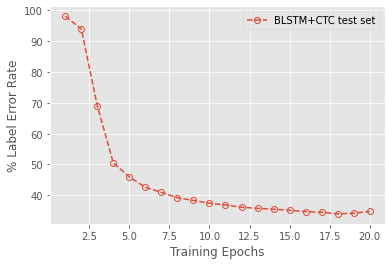

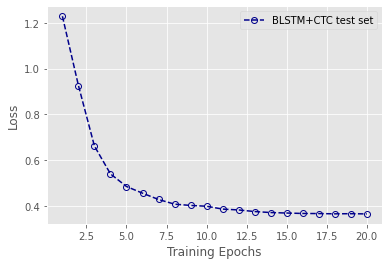

In [11]:
import datetime
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# ------------ Label error rates ----------------

fig, ax = plt.subplots()
epochs = np.arange(1, NUM_EPOCHS+1)
ax.plot(epochs, label_error_rates, '--o', markerfacecolor='None', label='BLSTM+CTC test set')

ax.set(xlabel='Training Epochs', ylabel='% Label Error Rate')

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/CTC/'
date_of_training = str(datetime.date.today())
filename = date_of_training + '_' + str(NUM_EPOCHS) + 'epochs' + suffix
learning_curve_filepath = root_path +'LER_' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()

# ------------ Losses ----------------

fig, ax = plt.subplots()
epochs = np.arange(1, NUM_EPOCHS+1)
ax.plot(epochs, losses, '--o', markerfacecolor='None', color='darkblue', label='BLSTM+CTC test set')

ax.set(xlabel='Training Epochs', ylabel='Loss')

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/CTC/'
date_of_training = str(datetime.date.today())
filename = date_of_training + '_' + str(NUM_EPOCHS) + 'epochs' + suffix
learning_curve_filepath = root_path +'loss_' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()